In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage.interpolation

import pickle
import io
import os
import time
from IPython.display import clear_output

In [2]:
#Traning parameters
learning_rate = 0.0002
BATCH_SIZE = 1
epochs = 100000

#Network Parameters
image_dimension = 12501

#Discriminator nodes
H_dim = 128

In [3]:
def xavier_init(shape):
  return tf.random_normal(shape = shape, stddev = 1./tf.sqrt(shape[0]/2.0))

In [4]:
import tensorflow.compat.v1 as tf

tf.disable_v2_behavior() 

#Defining the placeholders
X_A = tf.placeholder(tf.float32, shape = [None, image_dimension])
X_B = tf.placeholder(tf.float32, shape = [None, image_dimension])

Instructions for updating:
non-resource variables are not supported in the long term


In [5]:
#Define Weights and Bias dictionaries for Discriminator A

Disc_A_W = {"disc_H": tf.Variable(xavier_init([image_dimension, H_dim])),
            "disc_final": tf.Variable(xavier_init([H_dim, 1]))}

Disc_A_Bias = {"disc_H": tf.Variable(xavier_init([H_dim])),
            "disc_final": tf.Variable(xavier_init([1]))}

#Define Weights and Bias dictionaries for Discriminator A

Disc_B_W = {"disc_H": tf.Variable(xavier_init([image_dimension, H_dim])),
            "disc_final": tf.Variable(xavier_init([H_dim, 1]))}

Disc_B_Bias = {"disc_H": tf.Variable(xavier_init([H_dim])),
            "disc_final": tf.Variable(xavier_init([1]))}

#Define Weights and Bias dictionaries for Generator transforming A to B

Gen_AB_W = {"Gen_H": tf.Variable(xavier_init([image_dimension, H_dim])),
            "Gen_final": tf.Variable(xavier_init([H_dim, image_dimension]))}

Gen_AB_Bias = {"Gen_H": tf.Variable(xavier_init([H_dim])),
            "Gen_final": tf.Variable(xavier_init([image_dimension]))}

#Define Weights and Bias dictionaries for Generator transforming B to A

Gen_BA_W = {"Gen_H": tf.Variable(xavier_init([image_dimension, H_dim])),
            "Gen_final": tf.Variable(xavier_init([H_dim, image_dimension]))}

Gen_BA_Bias = {"Gen_H": tf.Variable(xavier_init([H_dim])),
            "Gen_final": tf.Variable(xavier_init([image_dimension]))}

In [6]:
def Disc_A(x):
  D_hidden_layer = tf.nn.relu(tf.add(tf.matmul(x, Disc_A_W["disc_H"]), Disc_A_Bias["disc_H"]))
  disc_output = tf.add(tf.matmul(D_hidden_layer, Disc_A_W["disc_final"]), Disc_A_Bias["disc_final"])
  disc_prob_output = tf.nn.sigmoid(disc_output)
  return disc_prob_output

def Disc_B(x):
  D_hidden_layer = tf.nn.relu(tf.add(tf.matmul(x, Disc_B_W["disc_H"]), Disc_B_Bias["disc_H"]))
  disc_output = tf.add(tf.matmul(D_hidden_layer, Disc_B_W["disc_final"]), Disc_B_Bias["disc_final"])
  disc_prob_output = tf.nn.sigmoid(disc_output)
  return disc_prob_output

def Gen_AB(x):
  G_hidden_layer = tf.nn.relu(tf.add(tf.matmul(x, Gen_AB_W["Gen_H"]), Gen_AB_Bias["Gen_H"]))
  gen_output = tf.add(tf.matmul(G_hidden_layer, Gen_AB_W["Gen_final"]), Gen_AB_Bias["Gen_final"])
  gen_prob_output = tf.nn.sigmoid(gen_output)
  return gen_prob_output

def Gen_BA(x):
  G_hidden_layer = tf.nn.relu(tf.add(tf.matmul(x, Gen_BA_W["Gen_H"]), Gen_BA_Bias["Gen_H"]))
  gen_output = tf.add(tf.matmul(G_hidden_layer, Gen_BA_W["Gen_final"]), Gen_BA_Bias["Gen_final"])
  gen_prob_output = tf.nn.sigmoid(gen_output)
  return gen_prob_output

In [7]:
# Building Cycle GAN metwork

#  GAN for approximating A distribution
X_BA = Gen_BA(X_B)
Disc_A_real = Disc_A(X_A)
Disc_A_fake = Disc_A(X_BA)

#  GAN for approximating B distribution
X_AB = Gen_AB(X_A)
Disc_B_real = Disc_B(X_B)
Disc_B_fake = Disc_B(X_AB)

In [8]:
# Discriminator Loss function

Loss_Disc_A = (tf.reduce_mean(tf.square(Disc_A_real - tf.ones_like(Disc_A_real)) + tf.reduce_mean(tf.square(Disc_A_fake))))/2.0
Loss_Disc_B = (tf.reduce_mean(tf.square(Disc_B_real - tf.ones_like(Disc_B_real)) + tf.reduce_mean(tf.square(Disc_B_fake))))/2.0

Disc_Loss =  Loss_Disc_A + Loss_Disc_B

In [9]:
# Image Reconstruction

X_BAB = Gen_AB(X_BA)
X_ABA = Gen_BA(X_AB)

In [10]:
# Generator Loss function
Loss_Gen_A = tf.reduce_mean(tf.square(Disc_B_fake - tf.ones_like(Disc_B_fake)))
Loss_Gen_B = tf.reduce_mean(tf.square(Disc_A_fake - tf.ones_like(Disc_A_fake)))
Loss_total = Loss_Gen_A + Loss_Gen_B

# Reconstruction Loss for Cycle GAN
Loss_reckon_A = tf.reduce_mean(10*tf.abs((X_A-X_ABA)))
Loss_reckon_B = tf.reduce_mean(10*tf.abs((X_B-X_BAB)))
Loss_reckon_total = Loss_reckon_A + Loss_reckon_B

Gen_Loss = Loss_total + Loss_reckon_total

In [11]:
# Parameters list of Discriminator

Disc_param = [Disc_A_W["disc_H"], Disc_A_W["disc_final"], Disc_A_Bias["disc_H"], Disc_A_Bias["disc_final"],
              Disc_B_W["disc_H"], Disc_B_W["disc_final"], Disc_B_Bias["disc_H"], Disc_B_Bias["disc_final"]]

# Parameters list of Generator

Gen_param = [Gen_AB_W["Gen_H"], Gen_AB_W["Gen_final"], Gen_AB_Bias["Gen_H"], Gen_AB_Bias["Gen_final"],
              Gen_BA_W["Gen_H"], Gen_BA_W["Gen_final"], Gen_BA_Bias["Gen_H"], Gen_BA_Bias["Gen_final"]]

# Define the optimiser

Gen_optimize = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(Gen_Loss, var_list = Gen_param)
Disc_optimize = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(Disc_Loss, var_list = Disc_param)

In [13]:
f1 = "/content/drive/MyDrive/Colab Notebooks/normal_X.bin"
f2 = "/content/drive/MyDrive/Colab Notebooks/normal_Y.bin"

with open(f1, mode='rb') as file:
    x = file.read()
    
with open(f2, mode='rb') as file:
    y = file.read()

def deserialize(data):
  serialized_sample = pickle.dumps(data)
  serialized_bytesio = io.BytesIO()
  np.save(serialized_bytesio, data, allow_pickle=False)
  serialized_bytesio.seek(0)
  result = np.ndarray(shape=len(data), dtype=np.uint8, buffer=data)

  return result

x = deserialize(x)
y = deserialize(y)

x = np.reshape(x, (80000, 12501))
y = np.reshape(y, (80000, 12501))

x_train, y_train = x[0:1000], y[0:10]
x_test, y_test = x[1000:1200], y[10:12]

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

x_train = (x_train - 127.5) / 127.5
y_train = (y_train - 127.5) / 127.5
x_test = (x_test - 127.5) / 127.5
y_test = (y_test - 127.5) / 127.5

# Random shuffling of data

def shuffle_data(x, size):
  start_index = np.random.randint(0, x.shape[0]-size)
  return x[start_index:start_index+size]

(1000, 12501) (10, 12501) (200, 12501) (2, 12501)


In [14]:
# Initialze the vrailables

init = tf.compat.v1.global_variables_initializer()

sess = tf.compat.v1.Session()
sess.run(init)

for epoch in range(epochs):
  X_A_batch = shuffle_data(x_train, BATCH_SIZE)
  X_B_batch = shuffle_data(y_train, BATCH_SIZE)

  _, Disc_loss_epoch = sess.run([Disc_optimize, Disc_Loss], feed_dict = {X_A:X_A_batch, X_B:X_B_batch})
  _, Gen_loss_epoch = sess.run([Gen_optimize, Gen_Loss], feed_dict = {X_A:X_A_batch, X_B:X_B_batch})

  if epoch%2000 == 0:
    print("Steps :{0}, Disc loss :{1}, Gen loss :{2}".format(epoch, Disc_loss_epoch, Gen_loss_epoch))

Steps :0, Disc loss :0.7206608057022095, Gen loss :20.470928192138672
Steps :2000, Disc loss :6.917964910920657e-17, Gen loss :15.842977523803711
Steps :4000, Disc loss :9.234721782647336e-17, Gen loss :18.475482940673828
Steps :6000, Disc loss :1.4273475278657363e-16, Gen loss :16.589706420898438
Steps :8000, Disc loss :1.0018680329793028e-09, Gen loss :15.547173500061035
Steps :10000, Disc loss :6.161940756939605e-16, Gen loss :17.019580841064453
Steps :12000, Disc loss :1.846441827763729e-16, Gen loss :16.27539825439453
Steps :14000, Disc loss :5.184561085805892e-16, Gen loss :15.278524398803711
Steps :16000, Disc loss :5.223882524468815e-12, Gen loss :15.028512954711914
Steps :18000, Disc loss :2.5268210426457457e-16, Gen loss :15.456871032714844
Steps :20000, Disc loss :3.602175955997179e-16, Gen loss :15.512552261352539
Steps :22000, Disc loss :3.6009530521795806e-16, Gen loss :14.89047622680664
Steps :24000, Disc loss :9.036647298510392e-13, Gen loss :15.458722114562988
Steps :2

In [21]:
# Saving the model

saver = tf.train.Saver([Gen_AB_W, Gen_AB_Bias, Gen_BA_W, Gen_BA_Bias])
saver.save(sess, '/content/drive/MyDrive/Colab Notebooks/RA/my_test_model')

'/content/drive/MyDrive/Colab Notebooks/my_test_model'

In [ ]:
# Loading the saved model



In [22]:
# Testing

test_A = shuffle_data(x_test, BATCH_SIZE)
test_B = shuffle_data(y_test, BATCH_SIZE)

# Generate A from B
Out_A = sess.run(X_BA, feed_dict = {X_B:test_B})

# Generate B from A
Out_B = sess.run(X_AB, feed_dict = {X_A:test_A})

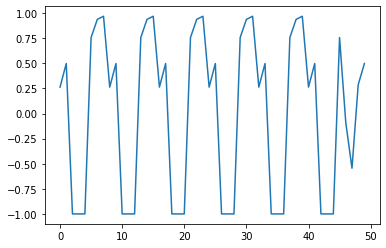

In [23]:
axis = range(50)
ar = test_A[0][0:50]
plt.plot(axis, ar)
plt.show()

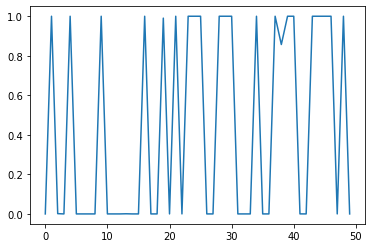

In [24]:
axis = range(50)
ar = Out_B[0][0:50]
plt.plot(axis, ar)
plt.show()

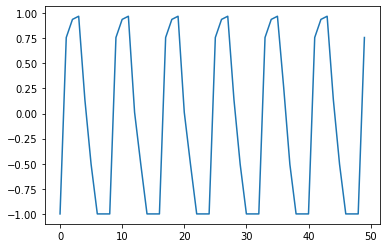

In [25]:
axis = range(50)
ar = test_B[0][0:50]
plt.plot(axis, ar)
plt.show()

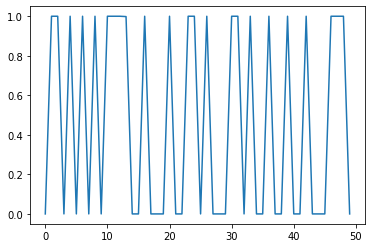

In [26]:
axis = range(50)
ar = Out_A[0][0:50]
plt.plot(axis, ar)
plt.show()